# **Overview**

The primary objective is to develop a machine learning model that predicts loan eligibility in real-time. By leveraging applicant data from online forms, the system automates decision-making to improve efficiency and reduce manual processing

#### **Workflow**

1. [Data Cleaning](#Data-Cleaning)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Feature Engineering](#Feature-Engineering)
4. [Data Transformation](#Data-Transformation)
5. [Model Training](#Model-Training)
6. [Model Evaluation](#Model-Evaluation)

In [1]:
# Uncomment the line below to install the dependencies
# !pip install -r requirements.txt

In [2]:
# Loading necessary packages abd libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, FunctionTransformer 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.pipeline import Pipeline
import joblib

# Makes transformers output pandas DataFrames with column names
set_config(transform_output="pandas")


In [3]:
# Load the datasets
df_train = pd.read_csv('loan_train.csv')
df_final_test = pd.read_csv('loan_test.csv')

print(f"Train Data has: {df_train.shape[0]} Rows, {df_train.shape[1]} Columns")
print(f"Test Data has: {df_final_test.shape[0]} Rows, {df_final_test.shape[1]} Columns")

Train Data has: 614 Rows, 13 Columns
Test Data has: 367 Rows, 12 Columns


In [4]:
df_train.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
print("Missing values before cleaning:")
print(df_train.isnull().sum())

Missing values before cleaning:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [7]:
# Get Numerical columns (int and float)
num_cols = df_train.select_dtypes(include=['number']).columns.tolist()

# Get Categorical columns (object and category)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [8]:
# Dropping the 'Loan_Id' and 'Loan_Status' from the list of categorical feature
cat_cols = cat_cols[1:7]
print(cat_cols)

num_cols = num_cols[:-1]
print(num_cols)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


### Data Cleaning

In [9]:
# Pipeline to fill missing values
missing_value_handler_pipeline = ColumnTransformer(transformers=[('cat_mode', SimpleImputer(strategy='most_frequent'), cat_cols),
    ('num_median', SimpleImputer(strategy='median'), num_cols),
    ('num_mode', SimpleImputer(strategy='most_frequent'), ['Credit_History']),], remainder="passthrough", verbose_feature_names_out=False)

cleaned_df_train = missing_value_handler_pipeline.fit_transform(df_train)
cleaned_df_train.head(15)

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_ID,Loan_Status
0,Male,No,0,Graduate,No,Urban,5849.0,0.0,128.0,360.0,1.0,LP001002,Y
1,Male,Yes,1,Graduate,No,Rural,4583.0,1508.0,128.0,360.0,1.0,LP001003,N
2,Male,Yes,0,Graduate,Yes,Urban,3000.0,0.0,66.0,360.0,1.0,LP001005,Y
3,Male,Yes,0,Not Graduate,No,Urban,2583.0,2358.0,120.0,360.0,1.0,LP001006,Y
4,Male,No,0,Graduate,No,Urban,6000.0,0.0,141.0,360.0,1.0,LP001008,Y
5,Male,Yes,2,Graduate,Yes,Urban,5417.0,4196.0,267.0,360.0,1.0,LP001011,Y
6,Male,Yes,0,Not Graduate,No,Urban,2333.0,1516.0,95.0,360.0,1.0,LP001013,Y
7,Male,Yes,3+,Graduate,No,Semiurban,3036.0,2504.0,158.0,360.0,0.0,LP001014,N
8,Male,Yes,2,Graduate,No,Urban,4006.0,1526.0,168.0,360.0,1.0,LP001018,Y
9,Male,Yes,1,Graduate,No,Semiurban,12841.0,10968.0,349.0,360.0,1.0,LP001020,N


In [10]:
print("Missing values after cleaning:")
print(cleaned_df_train.isnull().sum())

Missing values after cleaning:
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Property_Area        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Loan_ID              0
Loan_Status          0
dtype: int64


In [11]:
# Convert cleaned_df_train columns to original dtypes
cleaned_df_train = cleaned_df_train.astype({
    'Loan_ID': 'object',
    'Gender': 'object',
    'Married': 'object',
    'Dependents': 'object',
    'Education': 'object',
    'Self_Employed': 'object',
    'ApplicantIncome': 'int64',
    'CoapplicantIncome': 'float64',
    'LoanAmount': 'float64',
    'Loan_Amount_Term': 'float64',
    'Credit_History': 'float64',
    'Property_Area': 'object',
    'Loan_Status': 'object'
})
cleaned_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   Property_Area      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Loan_ID            614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [12]:
cleaned_df_train['Dependents'] = cleaned_df_train['Dependents'].replace('3+', '3')
cleaned_df_train['Dependents'] = pd.to_numeric(cleaned_df_train['Dependents'])

print(cleaned_df_train['Dependents'].value_counts())
cleaned_df_train.info()

Dependents
0    360
1    102
2    101
3     51
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   Property_Area      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Loan_ID            614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ KB


### Exploratory Data Analysis

Target Variable Distribution

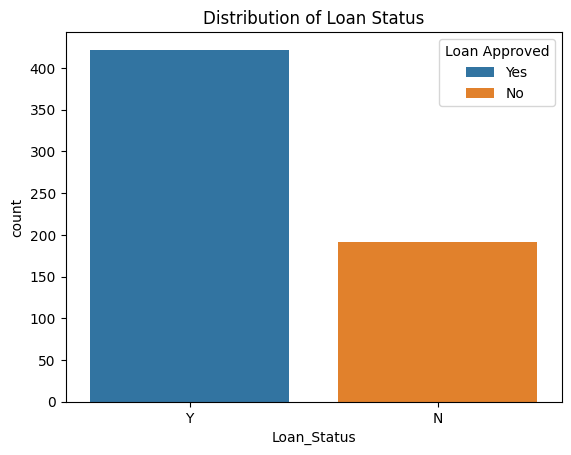

In [13]:
ax = sns.countplot(data=cleaned_df_train, x='Loan_Status', hue='Loan_Status')
plt.title('Distribution of Loan Status')
plt.legend(title='Loan Approved', labels=['Yes', 'No'])
plt.show()

Calculating the correlation matrix for all numerical columns.

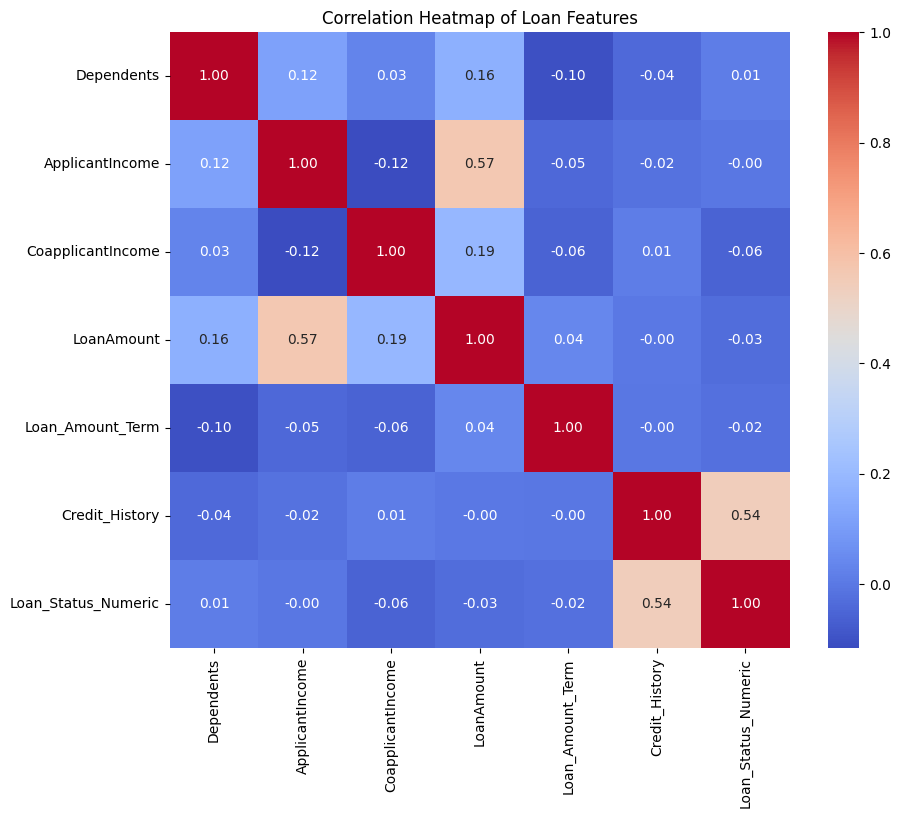

In [14]:
temp_df = cleaned_df_train.copy()
temp_df['Loan_Status_Numeric'] = temp_df['Loan_Status'].map({'Y': 1, 'N': 0})
numeric_data = temp_df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Loan Features')
plt.show()

Cross

Approval Percentage by Credit History:
Loan_Status             N          Y
Credit_History                      
0.0             92.134831   7.865169
1.0             20.952381  79.047619


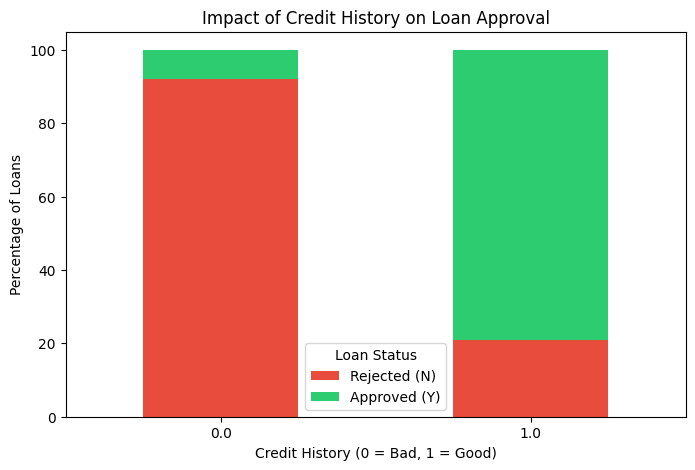

In [15]:
credit_impact = pd.crosstab(cleaned_df_train['Credit_History'], 
                            cleaned_df_train['Loan_Status'], 
                            normalize='index') * 100

print("Approval Percentage by Credit History:")
print(credit_impact)

# 2. Visualize with a stacked bar chart
credit_impact.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'], figsize=(8, 5))
plt.title('Impact of Credit History on Loan Approval')
plt.xlabel('Credit History (0 = Bad, 1 = Good)')
plt.ylabel('Percentage of Loans')
plt.legend(title='Loan Status', labels=['Rejected (N)', 'Approved (Y)'])
plt.xticks(rotation=0)
plt.show()

### Feature Engineering

In [16]:
def feature_engineering(df):
    df = df.copy()
    df['Dependents'] = df['Dependents'].replace('3+', '3')
    df['Dependents'] = pd.to_numeric(df['Dependents'])
    if {"ApplicantIncome", "CoapplicantIncome"}.issubset(df.columns):
        df["Total_Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]

    # Safe log helper: log(x) on x>0 else 0
    def safe_log(series):
        return np.log(np.where(series.astype(float) > 0, series.astype(float), 1.0))

    if "LoanAmount" in df.columns:
        df["LoanAmount_Log"] = safe_log(df["LoanAmount"])

    if "Total_Income" in df.columns:
        df["Total_Income_Log"] = safe_log(df["Total_Income"])
    cols_to_drop = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Total_Income"]
    if "Loan_ID" in df.columns:
        cols_to_drop.append("Loan_ID")

    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    return df

cleaned_df_train = feature_engineering(cleaned_df_train)
display(cleaned_df_train.head(10))



,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Amount_Term,Credit_History,Loan_Status,LoanAmount_Log,Total_Income_Log
0,Male,No,0,Graduate,No,Urban,360.0,1.0,Y,4.852030,8.674026
1,Male,Yes,1,Graduate,No,Rural,360.0,1.0,N,4.852030,8.714568
2,Male,Yes,0,Graduate,Yes,Urban,360.0,1.0,Y,4.189655,8.006368
3,Male,Yes,0,Not Graduate,No,Urban,360.0,1.0,Y,4.787492,8.505323
4,Male,No,0,Graduate,No,Urban,360.0,1.0,Y,4.948760,8.699515
5,Male,Yes,2,Graduate,Yes,Urban,360.0,1.0,Y,5.587249,9.170872
6,Male,Yes,0,Not Graduate,No,Urban,360.0,1.0,Y,4.553877,8.255569
7,Male,Yes,3,Graduate,No,Semiurban,360.0,0.0,N,5.062595,8.619750
8,Male,Yes,2,Graduate,No,Urban,360.0,1.0,Y,5.123964,8.618305
9,Male,Yes,1,Graduate,No,Semiurban,360.0,1.0,N,5.855072,10.077819


In [17]:
# Get Numerical columns (int and float)
num_cols = cleaned_df_train.select_dtypes(include=['number']).columns.tolist()

# Get Categorical columns (object and category)
cat_cols = cleaned_df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['Dependents', 'Loan_Amount_Term', 'Credit_History', 'LoanAmount_Log', 'Total_Income_Log']
Categorical columns: ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


### Data Transformation

In [18]:
data_trans_preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    
    # Ordinal Encoding for Education
    ('ord_cat', OrdinalEncoder(categories=[['Not Graduate', 'Graduate']]), ['Education']),
    
    # One-Hot Encoding for remaining categorical features
    ('nom_cat', OneHotEncoder(drop='first', sparse_output=False), 
     ['Gender', 'Married', 'Property_Area', 'Self_Employed'])
], verbose_feature_names_out=False)


features_final_df = data_trans_preprocessor.fit_transform(cleaned_df_train)

# Encode Target specifically
label_encoder = LabelEncoder()
target_final_df= label_encoder.fit_transform(cleaned_df_train['Loan_Status'])

In [19]:

features_final_df.head(15)

,Dependents,Loan_Amount_Term,Credit_History,LoanAmount_Log,Total_Income_Log,Education,Gender_Male,Married_Yes,Property_Area_Semiurban,Property_Area_Urban,Self_Employed_Yes
0,0,360.0,1.0,4.852030,8.674026,1.0,1.0,0.0,0.0,1.0,0.0
1,1,360.0,1.0,4.852030,8.714568,1.0,1.0,1.0,0.0,0.0,0.0
2,0,360.0,1.0,4.189655,8.006368,1.0,1.0,1.0,0.0,1.0,1.0
3,0,360.0,1.0,4.787492,8.505323,0.0,1.0,1.0,0.0,1.0,0.0
4,0,360.0,1.0,4.948760,8.699515,1.0,1.0,0.0,0.0,1.0,0.0
5,2,360.0,1.0,5.587249,9.170872,1.0,1.0,1.0,0.0,1.0,1.0
6,0,360.0,1.0,4.553877,8.255569,0.0,1.0,1.0,0.0,1.0,0.0
7,3,360.0,0.0,5.062595,8.619750,1.0,1.0,1.0,1.0,0.0,0.0
8,2,360.0,1.0,5.123964,8.618305,1.0,1.0,1.0,0.0,1.0,0.0
9,1,360.0,1.0,5.855072,10.077819,1.0,1.0,1.0,1.0,0.0,0.0


### Model Training 

In [20]:
# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(features_final_df, target_final_df,
                                                     test_size=0.2, random_state=42, stratify=target_final_df)


print("Training Shape:", X_train.shape)
print("Validation Shape:", X_test.shape)

Training Shape: (491, 11)
Validation Shape: (123, 11)


In [21]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    random_state=42
)
# Model Training
trained_model = rf_model.fit(X_train, y_train)
trained_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [22]:
# Predictions on Validation Set
y_pred = trained_model.predict(X_test)
y_pred

array([0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0])

### Model Evaluation

In [23]:
# Accuracy
print(f"Validation Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Validation Accuracy: 81.30%

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.63      0.68        38
           1       0.84      0.89      0.87        85

    accuracy                           0.81       123
   macro avg       0.79      0.76      0.77       123
weighted avg       0.81      0.81      0.81       123



**Confusion Matrix**

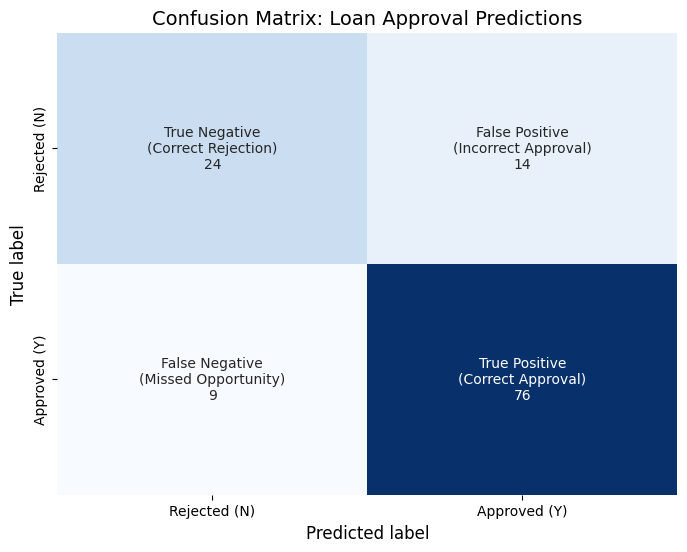

In [24]:
cm = confusion_matrix(y_test, y_pred)
group_names = ['True Negative\n(Correct Rejection)', 'False Positive\n(Incorrect Approval)', 
               'False Negative\n(Missed Opportunity)', 'True Positive\n(Correct Approval)']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Rejected (N)', 'Approved (Y)'],
            yticklabels=['Rejected (N)', 'Approved (Y)'])

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.title('Confusion Matrix: Loan Approval Predictions', fontsize=14)
plt.show()

### Saving the Model and Data Transformation Pipeline

In [25]:

def feature_names_out(input_features_1, input_features_2):
    return np.array([
        'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
        'Property_Area', 'Loan_Amount_Term', 'Credit_History',
        'LoanAmount_Log', 'Total_Income_Log'
    ], dtype=object
    )

feature_eng = FunctionTransformer(
    feature_engineering,
    validate=False,
    feature_names_out=feature_names_out
)

preprocessor = Pipeline(steps=[
    ("impute", missing_value_handler_pipeline),
    ("feature_eng", feature_eng),
    ("final_transform", data_trans_preprocessor),
])


preprocessor

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('feature_eng', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat_mode', ...), ('num_median', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of 

In [26]:
# Persist each artifact separately
joblib.dump(preprocessor, "loan_preprocessor.pkl")
joblib.dump(rf_model, "loan_model.pkl")

['loan_model.pkl']

In [28]:
# Predict on the real test file
pre = joblib.load("loan_preprocessor.pkl")
model = joblib.load("loan_model.pkl")
final_predictions = preprocessor.fit_transform(df_final_test)

In [29]:
final_predictions.head(15)

,Dependents,Loan_Amount_Term,Credit_History,LoanAmount_Log,Total_Income_Log,Education,Gender_Male,Married_Yes,Property_Area_Semiurban,Property_Area_Urban,Self_Employed_Yes
0,0,360.0,1.0,4.700480,8.651724,1.0,1.0,1.0,0.0,1.0,0.0
1,1,360.0,1.0,4.836282,8.428581,1.0,1.0,1.0,0.0,1.0,0.0
2,2,360.0,1.0,5.337538,8.824678,1.0,1.0,1.0,0.0,1.0,0.0
3,2,360.0,1.0,4.605170,8.494129,1.0,1.0,1.0,0.0,1.0,0.0
4,0,360.0,1.0,4.356709,8.094378,0.0,1.0,0.0,0.0,1.0,0.0
5,0,360.0,1.0,5.023881,8.628198,0.0,1.0,1.0,0.0,1.0,1.0
6,1,360.0,1.0,4.077537,7.707962,0.0,0.0,0.0,1.0,0.0,0.0
7,2,360.0,0.0,4.990433,8.263848,0.0,1.0,1.0,0.0,0.0,0.0
8,2,240.0,1.0,5.634790,9.520249,1.0,1.0,1.0,0.0,1.0,0.0
9,0,360.0,1.0,4.812184,8.476371,0.0,1.0,0.0,1.0,0.0,0.0


In [30]:
model.predict(final_predictions)

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,